# How to apply Monte Carlo simulation to forecast stock prices

[Tutorial Link](https://datascienceplus.com/how-to-apply-monte-carlo-simulation-to-forecast-stock-prices-using-python/)

---

## Imports

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf
%matplotlib inline

## Select ticker

In [98]:
#ticker = 'MSFT'
ticker = 'PG'
data = yf.download(ticker, start="2007-01-01")
#print(data['Adj Close'])
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-03,63.720001,64.660004,63.700001,64.540001,39.827568,9717900
2007-01-04,64.339996,64.500000,63.750000,64.050003,39.525192,8711400
2007-01-05,63.869999,64.000000,63.340000,63.500000,39.185791,9907900
2007-01-08,63.590000,63.779999,63.230000,63.639999,39.272171,11068200
2007-01-09,63.389999,63.799999,63.110001,63.480000,39.173435,10823800
...,...,...,...,...,...,...
2023-10-13,143.190002,145.029999,143.190002,144.690002,144.690002,7078900
2023-10-16,145.860001,147.059998,145.460007,146.070007,146.070007,6509800
2023-10-17,146.110001,146.820007,145.240005,146.259995,146.259995,6160100


### Adj Close

Adjusted Close price takes into account events such as stock splits and dividends payments. 

Using Adj Close gives a more accurate representation of a stock's value across time.

In [99]:
data = data['Adj Close']

# Estimate historical log returns 
log_returns = np.log(1 + data.pct_change())
log_returns.tail()

Date
2023-10-13    0.009514
2023-10-16    0.009492
2023-10-17    0.001300
2023-10-18    0.025449
2023-10-19   -0.011935
Name: Adj Close, dtype: float64

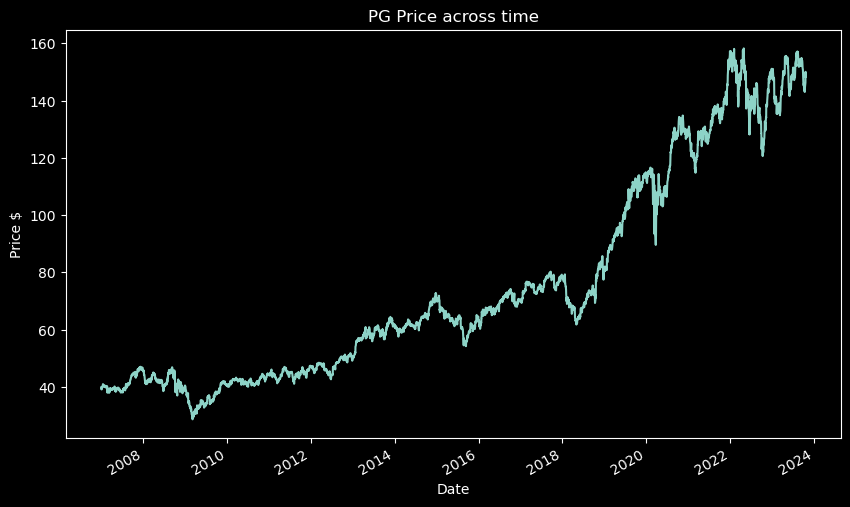

In [25]:
data.plot(figsize=(10,6))
plt.ylabel('Price $')
plt.title(f"{ticker} Price across time")
plt.show()

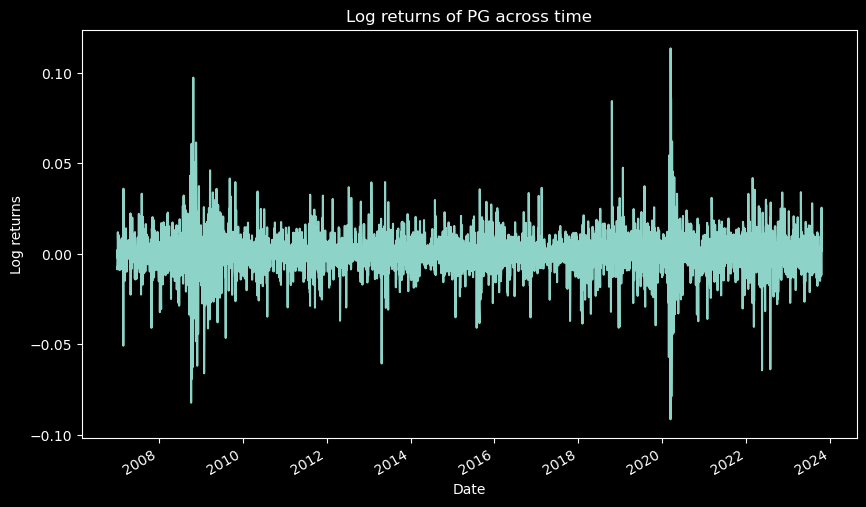

In [26]:
log_returns.plot(figsize = (10, 6))
plt.title(f"Log returns of {ticker} across time")
plt.ylabel('Log returns')
plt.show()

### Brownian Motion

$$r = drift + stdv * e^r$$

In [30]:
# Capture mean and variance for Brownian motion calculation
mean = log_returns.mean()
var = log_returns.var()
# drift is the best approximation of future rates 
drift = mean - (0.5 * var)
stdv = log_returns.std()

In [37]:
# second component of Brownian motion

# random variable z : numeric value corresponding to 
#     the distance between the mean and the events, 
#     expressed as the number of standard deviations


# ie : If an event has 95% chance of occuring, 
#      the distance between the mean and the event
#       ≈ 1.65 standard deviations
probability_of_occurance = 0.95
z = norm.ppf(probability_of_occurance)
z

1.6448536269514722

In [40]:
z = norm.ppf(np.random.rand(10, 2))
z

array([[ 0.11458403,  1.06225469],
       [ 0.09272179,  0.2624786 ],
       [-2.40564778,  0.25289441],
       [ 1.12353622, -0.93114425],
       [ 1.6708282 , -0.05702854],
       [-0.22152191, -0.98214566],
       [ 0.3084118 , -0.42139827],
       [-0.29444215, -0.62028   ],
       [ 0.31476375, -1.01100203],
       [-0.31806296,  1.72970756]])

In [63]:
t_intervals = len(data) # forecast for upcoming t_intervals days
iterations = 10 # number of series of future stock predictions

# daily_returns = e^r
daily_returns = np.exp(drift + stdv * norm.ppf(np.random.rand(t_intervals, iterations)))

In [64]:
print(f"{daily_returns.shape[1]} sets of {daily_returns.shape[0]} random future stock prices")
daily_returns

10 sets of 4229 random future stock prices


array([[1.00920947, 0.990458  , 0.97841878, ..., 1.00176538, 0.98688401,
        1.03221318],
       [0.99345905, 1.00700411, 1.02375605, ..., 0.98360547, 1.00444775,
        0.99988466],
       [0.98790738, 1.02324531, 0.99618405, ..., 1.00400294, 1.00586612,
        0.98619791],
       ...,
       [1.00966074, 0.99480079, 1.0003066 , ..., 1.00265749, 1.00098731,
        0.98433557],
       [1.00184183, 1.01156953, 0.97713006, ..., 1.00044253, 1.02241887,
        0.97707043],
       [0.99691377, 0.99725461, 1.01076594, ..., 0.9807336 , 0.98957343,
        0.9938295 ]])

In [68]:
#last_true_price = data.iloc[-1] # predict future
last_true_price = data.iloc[0] # backtest the whole chart
print(f"Last true price = ${last_true_price:.2f}")
predicted_prices = np.zeros_like(daily_returns)
# set last_true_price to the entire first row
# to generate (daily_returns.shape[1]) sets of predictions
predicted_prices[0] = last_true_price
for day in range(1, t_intervals):
    predicted_prices[day] = predicted_prices[day - 1] * daily_returns[day]

Last true price = $39.83


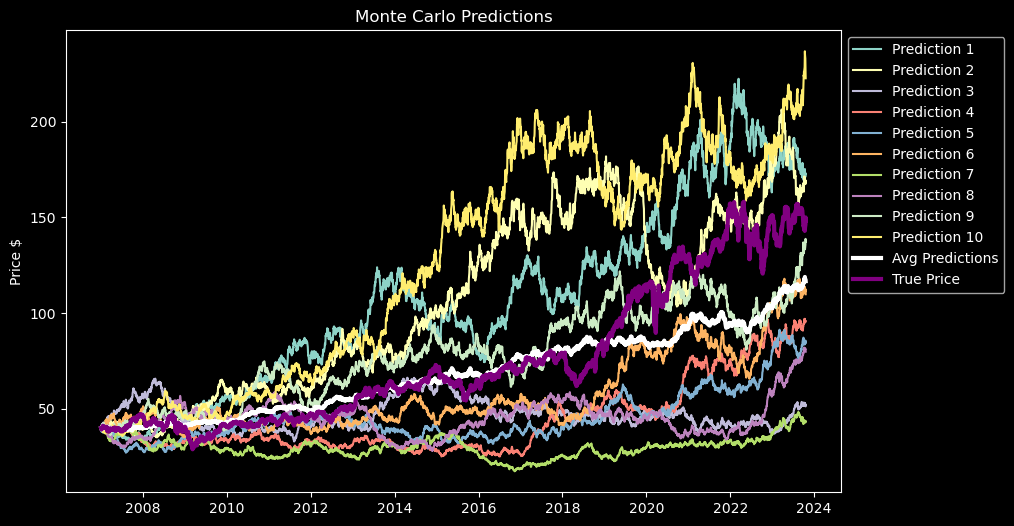

In [82]:
plt.figure(figsize=(10,6))
predicted_prices_df = pd.DataFrame(predicted_prices, index=data.index)

avg_predictions = predicted_prices_df.mean(axis=1)


for i in range(predicted_prices_df.shape[1]):
    plt.plot(predicted_prices_df.iloc[:, i], label=f'Prediction {i+1}')


plt.plot(avg_predictions, color='white', linewidth=3, label='Avg Predictions')

plt.plot(data, color='purple', linewidth=3, label='True Price')

plt.ylabel("Price $")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)  # Adjusted legend location for better visibility
plt.title("Monte Carlo Predictions")
plt.show()
